In [1]:
# forecast monthly births with random forest
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
from clean_test1 import get_merged_and_cleaned_data
import numpy as np
import pandas as pd

In [2]:
df = pd.read_pickle('data/data_combined_clean_2.pkl')

In [3]:
# siehe Slack 

#define train, validation and test dataset
train = df[df['Date'] < "2012-01-06"].reset_index(drop=True)
validation = df[(df['Date'] >= "2012-01-06") & (df['Date'] <= "2012-06-08")].reset_index(drop=True)
test = df[df['Date'] > "2012-06-08"].reset_index(drop=True)

# mit dem neuen Datensatz haben wir immer 143 Reihen --> d.h. 
# Train  - 100
# Val 100 - 122
# Test 122 - 143
##

In [4]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	#print (agg.values)	
	return agg.values

In [5]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	#data1 = (data[:-n_test])
	#data2 = data[-n_test:, :]
	#data 3 = data[:-n_test, :]
	return data[:-n_test, :], data[-n_test:, :]     #Erklärung: er nimmt die letzten Datenzeilen (Anzahl = n_test) als Test-Zeilen, d.h. bei z.B. 142 Zeilen ist, 
												    # 1-130 der Train
													#	131 - 142 der Testzeitraum; 12 entspricht 8 %, d.h. sollte bisschen hochgesetzt werden, z.B. auf 28 ( = 20 %)

In [6]:
# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = RandomForestRegressor(n_estimators=100)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict([testX])
	return yhat[0]

In [7]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]										# history sind die trainingsdaten einfach unter anderem Namen gespeichert...
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = random_forest_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = np.sqrt(mean_squared_error(test[:, -1], predictions))
	return error, test[:, -1], predictions

>expected=16976.2, predicted=28034.1
>expected=16347.6, predicted=17599.3
>expected=17147.4, predicted=17358.3
>expected=18164.2, predicted=15468.9
>expected=18517.8, predicted=19739.9
>expected=16963.5, predicted=19291.4
>expected=16065.5, predicted=16950.2
>expected=17666.0, predicted=16743.7
>expected=17558.8, predicted=17158.0
>expected=16633.4, predicted=16520.8
>expected=15722.8, predicted=16492.8
>expected=17823.4, predicted=15929.3
>expected=16566.2, predicted=18214.0
>expected=16348.1, predicted=16868.2
>expected=15731.2, predicted=17161.6
>expected=16628.3, predicted=16992.4
>expected=16119.9, predicted=16059.9
>expected=17330.7, predicted=16447.3
>expected=16286.4, predicted=18065.7
>expected=16680.2, predicted=16986.1
>expected=18322.4, predicted=16122.8
>expected=19616.2, predicted=20508.2
>expected=19251.5, predicted=19101.0
>expected=18947.8, predicted=18814.1
>expected=21904.5, predicted=16605.0
>expected=22764.0, predicted=23809.8
>expected=24185.3, predicted=28254.2
>

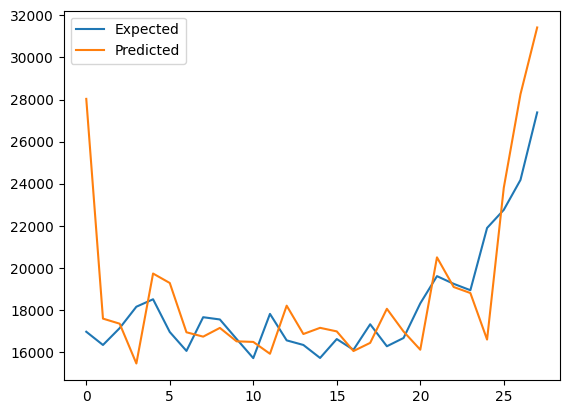

In [8]:
#--------------------------------------------------

# load the dataset
#df2 = df.query('Store == 1')['Weekly_Sales'].to_list()
df2 = df.query('Store == 1 and Dept == 1')['Weekly_Sales'].to_list()
data = series_to_supervised(df2,1,1)
#print (array)


#series = read_csv('daily-total-female-births.csv', header=0, index_col=0)
#values = series.values
# transform the time series data into supervised learning
#data = series_to_supervised(values, n_in=6)
# evaluate
rmse, y, yhat = walk_forward_validation(data, 28)
print ('------')
print('RMSE on test - observation points: %.3f' % rmse)
# plot expected vs predicted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()